## does further localising sparse representation help?

- previously we observed, localising to one layer, with sparse representation : demonstrate results, generalisable, beyond test cases to perturbed test cases as well. 

- within this sparse representation: although sparse it is nevertheless a large data dimension of 32768, can increase space and time complexity required compared to evaluating via the original probe of dimension 512

- 

Qualitatively: 
- previous works has observed effective disentanglement and interpretable properties with the latents 
- what "features" (input prompts) might these latents correspond to input space? 

Quantitatively: 
- 

In [23]:
from utils.probe_utils import load_probe, data_loader, test_probe
from utils.data_utils import read_from_pt_gz
import torch as t 
from tqdm import tqdm

sae_dim = 32768

In [ ]:
## train acts
harmful_fp = "data_latents/train/sparse_acts/harmful_sparse_acts_32768.pt.gz"
nonharmful_fp = "data_latents/train/sparse_acts/nonharmful_sparse_acts_32768.pt.gz"

harmful_sparse_acts_train = read_from_pt_gz(harmful_fp)
nonharmful_sparse_acts_train = read_from_pt_gz(nonharmful_fp)


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


In [17]:
## test acts 
## get test acts
nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
print('loaded test batches for Accuracy: ', len(test_batches))

# recall (test harmful)
# harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)
print('loaded test batches (harmful only) for Recall: ', len(test_batches_harmful))

# recall (test nonharmful)
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()
label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)
print('loaded test batches (nonharmful only) for Recall: ', len(test_batches_nonharmful))

# recall (perturbed)
harmful_acts_perturbed = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)
print('loaded test batches (perturbed) for Recall: ', len(test_batches_harmful_perturbed))


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


loaded test batches for Accuracy:  24
loaded test batches (harmful only) for Recall:  12
loaded test batches (nonharmful only) for Recall:  12
loaded test batches (perturbed) for Recall:  12


### probe

In [21]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth"
sparse_acts_probe = load_probe(filepath, dim=sae_dim)
sparse_acts_probe

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/probe_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(filepath))


Probe(
  (net): Linear(in_features=32768, out_features=1, bias=True)
)

In [ ]:
probe = sparse_acts_probe
test_acc = test_probe(probe, test_batches)
# print(test_acc)


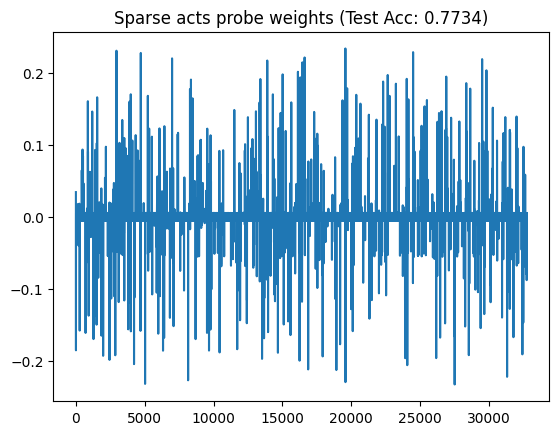

In [27]:
import matplotlib.pyplot as plt
plt.title(f"Sparse acts probe weights (Test Acc: {test_acc:.4f})")
plt.plot(sparse_acts_probe.net.weight.squeeze().detach().numpy())

In [13]:
corr_latents_top_100 = abs(sparse_acts_probe.net.weight.squeeze()).topk(100)
# print('indices', corr_latents_top_100['indices'])
corr_latents_top_100.indices

tensor([19584, 27524,  5028,  2948, 19589, 24504,  4716,  8155, 31335, 16620,
         6989, 29521, 13906, 16458, 18928, 16879, 24081,  4225, 29833, 16135,
        16254,  2443, 15025, 13528, 22660, 23935, 26184, 26914, 17932, 16308,
         1980,  2862, 28554, 24041, 13405, 32446,  8362, 14681, 10442, 22326,
         6332,  9674, 28368,     5, 23254, 11723, 19713, 28655,  8291, 19200,
         3987, 14314,  8698,  1279, 20375, 13673,  5228,  6412, 22795, 26469,
        31796, 27541,  1546,  1858,  8476, 15595, 24162,  5986, 25509, 19375,
          703,  9528,   869, 13964,  3898,  3994, 15651, 13347, 20118,  4695,
          276, 20677,  9779,  3803, 29413, 25335, 28287,  7097, 30296,  1503,
        15104, 11511, 26829, 12420, 32511, 26571, 13084,  1187, 17315, 15421])

In [ ]:
### top 100 by causal effect

tensor([19584, 27524,  5028,  2948, 19589, 24504,  4716,  8155, 31335, 16620,
         6989, 29521, 13906, 16458, 18928, 16879, 24081,  4225, 29833, 16135,
        16254,  2443, 15025, 13528, 22660, 23935, 26184, 26914, 17932, 16308,
         1980,  2862, 28554, 24041, 13405, 32446,  8362, 14681, 10442, 22326,
         6332,  9674, 28368,     5, 23254, 11723, 19713, 28655,  8291, 19200,
         3987, 14314,  8698,  1279, 20375, 13673,  5228,  6412, 22795, 26469,
        31796, 27541,  1546,  1858,  8476, 15595, 24162,  5986, 25509, 19375,
          703,  9528,   869, 13964,  3898,  3994, 15651, 13347, 20118,  4695,
          276, 20677,  9779,  3803, 29413, 25335, 28287,  7097, 30296,  1503,
        15104, 11511, 26829, 12420, 32511, 26571, 13084,  1187, 17315, 15421])

In [43]:
# gather ablation effects for one layer
# last token activations 

acts = harmful_sparse_acts_train
probe = sparse_acts_probe

# based on last token
active_latents = len(acts.mean(dim=(1)).nonzero()[:, 1].unique())

ablation_effects = t.zeros(sae_dim)

full_acts = acts.mean(dim=1)
logits = probe(full_acts)

for latent_idx in tqdm(range(1, active_latents)): 
    ablated_acts = full_acts.clone()
    # ablate latent
    ablated_acts[:, latent_idx] = 0.0
    # compute logits_with_ablation
    logits_with_ablation = probe(ablated_acts)

    ablation_effects[latent_idx] = (logits - logits_with_ablation).mean() # over prompts

harmful_causal_dist = ablation_effects


# text_x = 20  # X-coordinate for the text
# text_y = 0.5  # Y-coordinate for the text
# plt.text(text_x, text_y, "This is a key region", fontsize=12, color="red")

# plt.text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')


 35%|███▍      | 1482/4285 [00:02<00:04, 651.94it/s]

: 

In [ ]:
# import matplotlib.pyplot as plt
plt.title(f"Causal Distribution over Sparse Representation of mean tokens (harmful)")
plt.plot(harmful_causal_dist.detach().numpy())
# Add text to the plot
# plt.xlabel()
plt.ylabel("Sparse latent index (Non-zero)")

In [28]:
acts = harmful_sparse_acts_train
probe = sparse_acts_probe

# active latents of last tok activations 
active_latents = len(acts[:, -1, :].nonzero()[:, 1].unique())

ablation_effects = t.zeros(sae_dim)

# last tok activations of the batch
full_acts = acts[:, -1, :]
logits = probe(full_acts)

for latent_idx in tqdm(range(1, active_latents)): 
    ablated_acts = full_acts.clone()
    # ablate last tok activation of latent idx
    ablated_acts[:, latent_idx] = 0.0
    # compute logits_with_ablation
    logits_with_ablation = probe(ablated_acts)

    ablation_effects[latent_idx] = (logits - logits_with_ablation).mean() # over prompts

harmful_causal_dist = ablation_effects
print(len(harmful_causal_dist))

100%|██████████| 511/511 [00:00<00:00, 578.13it/s]


32768


In [ ]:
harmful_causal_dist.nonzero().numel() # 576

576

In [30]:
harmful_causal_dist.max(), harmful_causal_dist.mean(), harmful_causal_dist.min()

(tensor(0.0227, grad_fn=<MaxBackward1>),
 tensor(9.2457e-07, grad_fn=<MeanBackward0>),
 tensor(-0.0197, grad_fn=<MinBackward1>))

In [ ]:
harmful_causal_dist.topk(10)
### representing latents "contributing" (having most logits impact on classification of harmful prompts

torch.return_types.topk(
values=tensor([0.0326, 0.0201, 0.0104, 0.0101, 0.0084, 0.0079, 0.0065, 0.0062, 0.0053,
        0.0049], grad_fn=<TopkBackward0>),
indices=tensor([2180, 1546, 3978, 3898, 2977,  427, 3370,  141,  319,  552]))

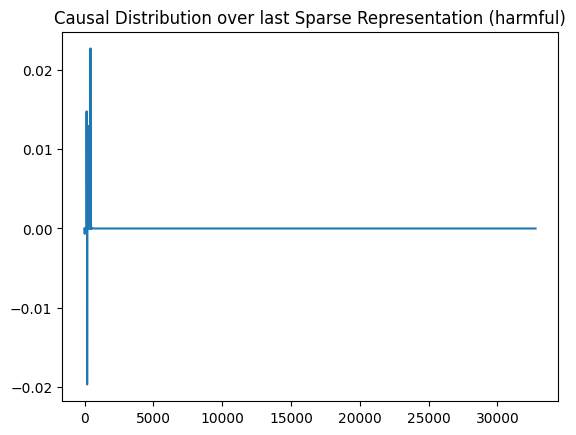

In [ ]:
import matplotlib.pyplot as plt
plt.title(f"Causal Distribution over last Sparse Representation (harmful)")
plt.plot(harmful_causal_dist.detach().numpy())

### only afew have significant causal effects 

In [ ]:
harmful_causal_dist.topk(100)

### causal distribution probe?

In [ ]:
# gather ablation effects for one layer
# last token activations 

acts = harmful_sparse_acts_train
probe = sparse_acts_probe

# based on last token
active_latents = len(acts.mean(dim=(1)).nonzero()[:, 1].unique())

ablation_effects = t.zeros(sae_dim)

full_acts = acts.mean(dim=1)
logits = probe(full_acts)

for latent_idx in tqdm(range(1, active_latents)): 
    ablated_acts = full_acts.clone()
    # ablate latent
    ablated_acts[:, latent_idx] = 0.0
    # compute logits_with_ablation
    logits_with_ablation = probe(ablated_acts)

    ablation_effects[latent_idx] = (logits - logits_with_ablation).mean() # over prompts

harmful_causal_dist = ablation_effects


In [ ]:
## viz comparison of causal distribution

    harmful_data = harmful_acts
    nonharmful_data = nonharmful_acts

    harmful_stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
    nonharmful_stats = {
        "max": nonharmful_data.max(),
        "mean": nonharmful_data.mean(),
        "median": nonharmful_data.median(),
        "min": nonharmful_data.min(), 
        "kurtosis": kurtosis(nonharmful_data)
    }

    # Create two subplots stacked vertically
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Plot non-harmful data
    axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
    axes[0].set_title("Averaged Non-Harmful Original Activations (n=64)")
    # axes[0].legend()
    axes[0].set_ylabel("Activation Value")

    # Annotate statistics
    axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
    axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
    axes[0].text(1.25, 0.7, f"Median: {nonharmful_stats['median']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
    axes[0].text(1.25, 0.6, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
    axes[0].text(1.25, 0.5, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

    # Plot harmful data
    axes[1].plot(harmful_data, label="Harmful data", color='red')
    axes[1].set_title("Averaged Harmful Original Activations (n=64)")

    axes[1].set_xlabel("Hidden dimensions Index")
    axes[1].set_ylabel("Activation Value")
    # Annotate statistics
    axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
    axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
    axes[1].text(1.25, 0.7, f"Median: {harmful_stats['median']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
    axes[1].text(1.25, 0.6, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
    axes[1].text(1.25, 0.5, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

## top 100 corr probe:

In [ ]:
### get train activations by (top 100 latents)
harmful_sparse_acts_train.shape

In [ ]:
### train probe

In [ ]:
### test probe

test_acc = test_probe(probe, test_batches)
recall_harmful = test_probe(probe, test_batches_harmful)
# recall_harmful = test_probe(probe, test_batches)
recall_perturbed = test_probe(probe, test_batches_harmful_perturbed)

print('Test Accuracy: ', test_acc)
print('Recall (harmful testset): ', recall_harmful)
print('Recall (harmful testset perturbed): ', recall_perturbed)


## top 100 causal probe:

In [ ]:
### most relevant by max acts

In [ ]:
### most relevant by correlation wrt concept probe

In [ ]:
### most relevant by causation wrt concept probe

### qualitative
- as ways to locate latents to inspect?

- amongst all activated latents
- 

### harm relevant latents?

### quantitative

- based on all these "harm relevant latents"

- top 100: corr
- top 100 causal

In [ ]:
## get top by weights;

In [ ]:
# get top by ablation effects

In [ ]:
## 

In [ ]:
### get train acts
nonharmful_acts = read_from_pt_gz("data_latents/train/acts/nonharmful_acts_512.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/train/acts/harmful_acts_512.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )

train_batches = data_loader(last_tok_acts_data, label)
len(train_batches)